In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization, Input, Embedding,Dot, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

from wordcloud import WordCloud

%matplotlib inline

In [2]:
import os

In [3]:
INPUT_DIR = os.path.join("..","artifacts","raw")

rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv",low_memory= True, usecols=["user_id","anime_id","rating"])

In [4]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [5]:
len(rating_df)

5000000

##### DATA Processing 

In [6]:
n_ratings = rating_df["user_id"].value_counts()
n_ratings

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
106          1
6846         1
92           1
26           1
10703        1
Name: count, Length: 15186, dtype: int64

In [7]:
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings>=400].index)].copy()
len(rating_df)

3246641

In [11]:
min_rating = min(rating_df["rating"])
max_rating = max(rating_df["rating"])
min_rating,max_rating

(0, 10)

In [12]:
avg_rating = np.mean(rating_df["rating"])
avg_rating

np.float64(4.122732695114736)

In [13]:
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [14]:
rating_df.duplicated().sum()

np.int64(0)

In [15]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [16]:
userids = rating_df["user_id"].unique().tolist()

user2user_encoded = {x:i for i, x in enumerate(userids)}
user2user_decoded = {i:x for i, x in enumerate(userids)}


In [17]:
rating_df["user"]=rating_df["user_id"].map(user2user_encoded)

In [18]:
n_users = len(user2user_encoded)
n_users

4203

In [19]:
anime_ids = rating_df["anime_id"].unique().tolist()

anime2anime_encoded = {x:i for i, x in enumerate(anime_ids)}
anime2anime_decoded = {i:x for i, x in enumerate(anime_ids)}
rating_df["anime"]=rating_df["anime_id"].map(anime2anime_encoded)

In [20]:
n_animes = len(anime2anime_encoded)
n_animes

17149

In [21]:
rating_df = rating_df.sample(frac=1,random_state=43).reset_index(drop=True)

In [22]:
rating_df.head(3)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216
2,6313,23325,0.0,1591,1239


In [23]:
X = rating_df[["user","anime"]].values
y = rating_df[["rating"]]

In [24]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [25]:
X_train, X_test, y_train,y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [26]:
len(X_train), len(X_test), len(y_train),len(y_test)

(3245641, 1000, 3245641, 1000)

In [27]:
type(X_train), type(X_test), type(y_train),type(y_test)

(numpy.ndarray,
 numpy.ndarray,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

In [28]:
X_train_array = [X_train[:,0],X_train[:,1]]
X_test_array = [X_test[:,0],X_test[:,1]]

#### Model Architecture

In [34]:
def RecommenderNet():
    embedding_size = 128

    user = Input(name = "user", shape=[1])
    user_embedding = Embedding(name="user_embedding", input_dim = n_users, output_dim= embedding_size)(user)

    anime = Input(name = "anime", shape=[1])
    anime_embedding = Embedding(name="anime_embedding", input_dim = n_animes, output_dim= embedding_size)(anime)
    

    x = Dot(name = "dot_product", normalize= True, axes = 2)([user_embedding,anime_embedding])

    x = Flatten()(x)

    x = Dense(1,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs = [user,anime], outputs = x)

    model.compile(loss='binary_crossentropy',metrics=['mse','mae'], optimizer = 'Adam')

    return model


In [37]:
model = RecommenderNet()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │          2 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [38]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch+start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr)*exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_lr

In [39]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch), verbose=0)
checkpoint_filepath = "./weights.weights.h5"


model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True)

early_stopping = EarlyStopping(patience=3,monitor='val_loss',mode='min',restore_best_weights=True)


In [40]:
my_callbacks = [lr_callback,model_checkpoint,early_stopping]

In [42]:
history = model.fit(
            x=X_train_array,
            y=y_train,
            batch_size = batch_size,
            epochs=20,
            verbose=1,
            validation_data = (X_test_array,y_test),
            callbacks = my_callbacks
        )

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7983 - mae: 0.3817 - mse: 0.1966 - val_loss: 0.7193 - val_mae: 0.3652 - val_mse: 0.1676 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7951 - mae: 0.3804 - mse: 0.1953 - val_loss: 0.7806 - val_mae: 0.3741 - val_mse: 0.1898 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.7894 - mae: 0.3783 - mse: 0.1930 - val_loss: 0.7862 - val_mae: 0.3749 - val_mse: 0.1914 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.7811 - mae: 0.3750 - mse: 0.1897 - val_loss: 0.7825 - val_mae: 0.3741 - val_mse: 0.1900 - learning_rate: 3.4000e-05


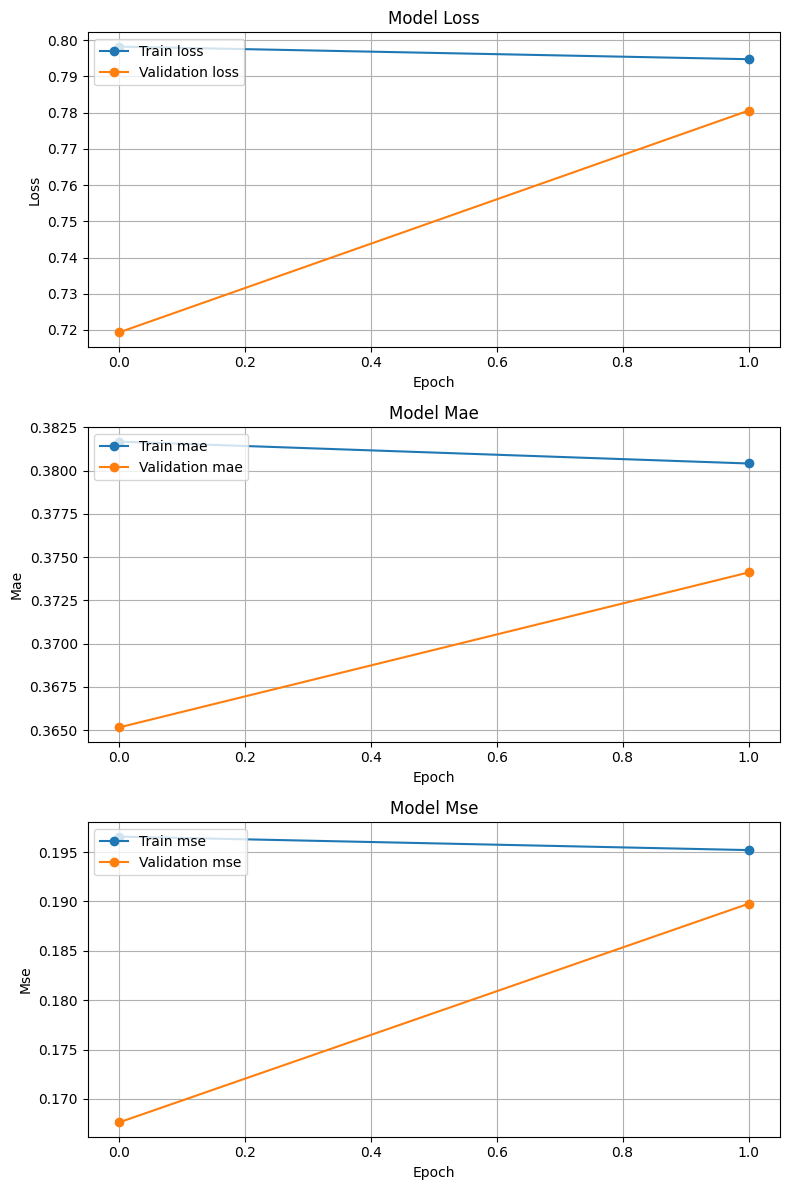

In [43]:
metrics = ['loss', 'mae', 'mse']

fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    ax.plot(history.history[metric][:-2], marker="o", label=f'Train {metric}')

    ax.plot(history.history[f"val_{metric}"][:-2], marker="o", label=f'Validation {metric}')
    
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel(metric.capitalize())

    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()


In [46]:
def extract_weights(name,model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

In [47]:
anime_weights = extract_weights('anime_embedding',model)
user_weights = extract_weights('user_embedding',model)

#### Reading Anime.csv

In [64]:
df = pd.read_csv(INPUT_DIR+"/anime.csv", low_memory = True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [65]:
df = df.replace("Unknown", np.nan)

In [66]:
def get_anime_name(animeid):
    try:
        name = df[df.anime_id == animeid].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == animeid].Name.values[0]

    except:
        print("Error")
    return name

In [67]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]

df["eng_version"]= df.anime_id.apply(lambda x:get_anime_name(x))

In [68]:
df.sort_values(by = ["Score"],
               inplace= True,
               ascending=False,
               kind='quicksort',
               na_position='last')

In [69]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [70]:
df = df[['anime_id','eng_version','Score', 'Genres', 'Episodes','Type', 'Premiered','Members']]
df.head(1)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456


In [71]:
def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df.anime_id == anime]
    if isinstance(anime,str):
        return df[df.eng_version == anime]


In [72]:
getAnimeFrame(40028,df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [73]:
getAnimeFrame("Fullmetal Alchemist:Brotherhood",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456


#### Anime with synposis

In [75]:
cols = ["MAL_ID", "Name", "Genres", "sypnopsis"]

synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv",usecols=cols, low_memory = True)

In [93]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."


In [126]:
def getSynopsis(anime,df):
    if isinstance(anime, int):
        anime_data = df[df.MAL_ID == anime]
    elif isinstance(anime, str):
        anime_data = df[df.Name == anime]
    else:
        return "" 

    if anime_data.empty:
        return ""

    return anime_data["sypnopsis"].values[0]

In [127]:
getSynopsis(40028,synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [128]:
getSynopsis("Fullmetal Alchemist: Brotherhood",synopsis_df)

'"In order for something to be obtained, something of equal value must be lost." Alchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible price for their transgression—Edward loses his left leg, Alphonse his physical body. It is only by the desperate sacrifice of Edward\'s right arm that he is able to affix Alphonse\'s soul to a suit of armor. Devastated and alone, it is the hope that they would both eventually return to their original bodies that gives Edward the inspiration to obtain metal limbs called "automail" and become a state alchemist, the Fullmetal Alchemist. Three years of searching later, the brothers seek the Philosopher\'s Stone, a mythical relic that allows an alchemist to overcome the Law of Equivalent Exchange. Even with military allies Colonel Roy Mustang, Lieutenant Riza Hawkeye, and Lieutenant Colonel Maes Hughes 

### CONTENT BASED RECOM

In [129]:
pd.set_option("max_colwidth",None)

In [207]:
def find_similar_animes(name,
                        anime_weights,
                        anime2anime_encoded,
                        anime2anime_decoded,
                        df, synopsis_df, n=10,
                        return_dist=False, neg=False):
    try:
        index = getAnimeFrame(name, df).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)

        if encoded_index is None:
            raise ValueError(f"Encoded index not found for anime ID {index}")

        weights = anime_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n = n + 1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        # print(f"Anime closest to {name}: {closest}")

        if return_dist:
            return dists, closest

        SimilarityArr = []
        for close in closest:
            decoded_id = anime2anime_decoded.get(close)
            if decoded_id is None:
                continue  

            synopsis = getSynopsis(decoded_id, synopsis_df)
            anime_frame = getAnimeFrame(decoded_id, df)

            if anime_frame.empty:
                continue 

            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[close]

            SimilarityArr.append({
                "anime_id": decoded_id,
                "name": anime_name,
                "similarity": similarity,
                "genre": genre,
                "synopsis": synopsis
            })

        if not SimilarityArr:
            raise ValueError("No similar animes found.")

        frame = pd.DataFrame(SimilarityArr)
        

        # print("Final DataFrame Columns:", frame.columns)

        frame = frame.sort_values(by="similarity", ascending=False)
        # return frame 
        return frame[frame.anime_id != index].drop(["anime_id"], axis=1)

    except Exception as e:
        print(f"Error occurred: {e}")
        raise


In [ ]:
find_similar_animes("Steins;Gate",
                        anime_weights,
                        anime2anime_encoded,
                        anime2anime_decoded,
                        df,synopsis_df)

#### USER BASED RECOMENDATION

In [210]:
def find_similar_users(item_input,
                        user_weights,
                        user2user_encoded,
                        user2user_decoded,
                        n=10,
                        return_dist=False, neg=False):
    
    try :
        index = item_input

        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n = n + 1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        if return_dist:
            return dists, closest
        

        SimilarityArr = []
        for close in closest:
            similarity = dists[close]

            if isinstance(item_input, int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" :decoded_id,
                    "similarity": similarity
                })
        frame = pd.DataFrame(SimilarityArr)
        

        # print("Final DataFrame Columns:", frame.columns)

        frame = frame.sort_values(by="similarity", ascending=False)
        return frame[frame.similar_users != item_input]

    except Exception as e:
        print(f"Error occurred: {e}")
        raise
 

In [143]:
simialar_user = find_similar_users(int(11880),
                        user_weights,
                        user2user_encoded,
                        user2user_decoded
                        )

Final DataFrame Columns: Index(['similar_users', 'similarity'], dtype='object')


In [144]:
simialar_user

,similar_users,similarity
9,12087,0.305990
8,6194,0.301349
7,14767,0.299831
6,5534,0.297459
5,3621,0.288704
4,9778,0.274342
3,7543,0.263417
2,2805,0.253243
1,11003,0.248799
0,1858,0.246049


In [145]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [146]:
from collections import defaultdict
def getFavGenre(frame , plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)
    
    return genres_list



In [162]:
def get_user_preferences(user_id,rating_df,df, plot=False):
    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by = "rating", ascending = False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if plot:
        getFavGenre(anime_df_rows,plot)
    return anime_df_rows

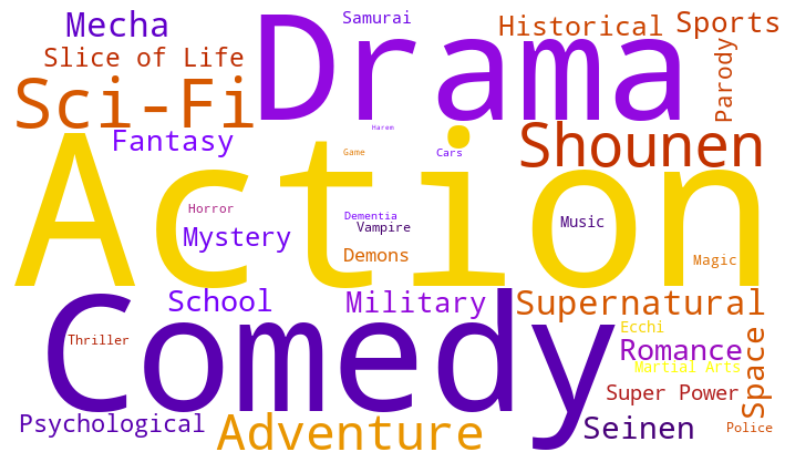

In [166]:
user_pref= get_user_preferences(11880,rating_df,df,True)

In [176]:
def get_user_recommendation(simialar_users,user_pref,rating_df,df,synopsis_df,n=10):

    recommended_animes = []
    anime_list = []

    for userid in simialar_users.similar_users.values:
        pref_list = get_user_preferences(int(userid),rating_df,df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list :
        anime_list = pd.DataFrame(anime_list)

        sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

        for i, anime_name in enumerate(sorted_list.index):
            n_user_pref = sorted_list[sorted_list.index == anime_name].values[0]

            if isinstance(anime_name,str):
                frame = getAnimeFrame(anime_name,df)
                anime_id = frame.anime_id.values[0]
                genre = frame.Genres.values[0]
                synopsis = getSynopsis(int(anime_id),synopsis_df)

                recommended_animes.append({
                    "n": n_user_pref,
                    "anime_name": anime_name,
                    "Genres" : genre,
                    "Synopsis": synopsis
                })

    return pd.DataFrame(recommended_animes).head(n)



In [ ]:
get_user_recommendation(simialar_user,user_pref,rating_df,df,synopsis_df)

#### HYBRID RECOMENDATION

In [220]:
def hybrid_recommendation(user_id,user_weight=0.5,content_weight = 0.5):
    #### User recommendation
    simialar_user = find_similar_users(user_id,
                        user_weights,
                        user2user_encoded,
                        user2user_decoded
                        )
    
    user_pref= get_user_preferences(user_id,rating_df,df)
    user_recommended_anime = get_user_recommendation(simialar_user,user_pref,rating_df,df,synopsis_df)

    user_recommended_anime_list = user_recommended_anime["anime_name"].to_list()
    print(user_recommended_anime_list)
    ##### Content Recomendation
    content_recommended_anime = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime,
                        anime_weights,
                        anime2anime_encoded,
                        anime2anime_decoded,
                        df,synopsis_df)
        if similar_animes is not None and not similar_animes.empty:
            # print(similar_animes)
            content_recommended_anime.extend(similar_animes["name"].tolist())

        else:
            print(f"No Similar Animes found {anime}")


    
    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight
    
    for anime in content_recommended_anime:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight

    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] , reverse=True)
    return [anime for anime, score in sorted_animes[:10]]

In [219]:
hybrid_recommendation(13994)

['Bakuman.', 'GATE', 'The Future Diary', "Yamada's First Time:B Gata H Kei", 'Overlord', 'Full Metal Panic? Fumoffu', 'Princess Mononoke', 'Baka & Test - Summon the Beasts', 'Naruto', 'High School of the Dead']


['Bakuman.',
 'GATE',
 'The Future Diary',
 "Yamada's First Time:B Gata H Kei",
 'Overlord',
 'Full Metal Panic? Fumoffu',
 'Princess Mononoke',
 'Baka & Test - Summon the Beasts',
 'Naruto',
 'High School of the Dead']